## **THỰC HÀNH CHƯƠNG III**

### **Câu 1:**

Hãy viết câu lệnh SQL để tính sự tương quan giữa A và B theo công thức sau:
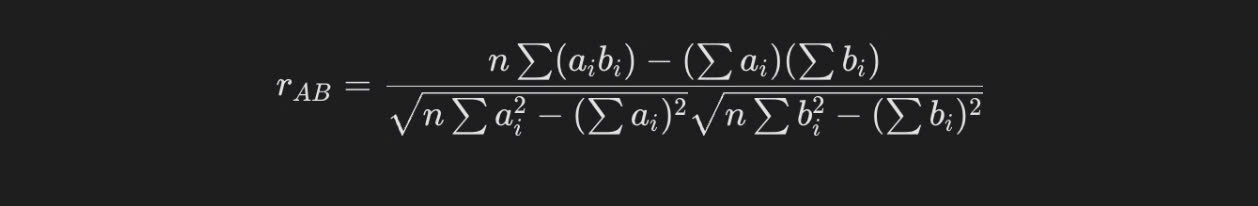

In [9]:
import sqlite3
import pandas as pd

def connect_db(db_name='example.db'):
    return sqlite3.connect(db_name)

def create_table(conn):
    with conn:
        conn.execute('''
            CREATE TABLE IF NOT EXISTS data_table (
                A REAL,
                B REAL
            )
        ''')

def insert_sample_data(conn, data):
    cursor = conn.cursor()
    cursor.execute('SELECT COUNT(*) FROM data_table')
    if cursor.fetchone()[0] == 0:
        conn.executemany('INSERT INTO data_table (A, B) VALUES (?, ?)', data)
        conn.commit()

def calculate_pearson_correlation(conn):
    df = pd.read_sql_query('SELECT A, B FROM data_table', conn)
    correlation = df['A'].corr(df['B'], method='pearson')
    return correlation

def interpret_correlation(r):
    if pd.isna(r):
        print("⚠️ Không thể tính hệ số tương quan do dữ liệu không đủ hoặc đồng nhất.")
    else:
        print(f"Hệ số tương quan Pearson giữa A và B: {r:.4f}")
        if r == 1.0:
            print("Kết luận: A và B có mối tương quan tuyến tính **hoàn hảo và dương**.")
            print("Vì B = 2A, nên B tăng gấp đôi khi A tăng – mối quan hệ tuyến tính hoàn hảo.")
        else:
            print("Kết luận: A và B có mối tương quan, nhưng không hoàn hảo.")

def main():
    sample_data = [(1, 2), (2, 4), (3, 6), (4, 8), (5, 10)]
    
    conn = connect_db()
    create_table(conn)
    insert_sample_data(conn, sample_data)
    
    correlation = calculate_pearson_correlation(conn)
    interpret_correlation(correlation)

    conn.close()

if __name__ == "__main__":
    main()


Hệ số tương quan Pearson giữa A và B: 1.0000
Kết luận: A và B có mối tương quan tuyến tính **hoàn hảo và dương**.
Vì B = 2A, nên B tăng gấp đôi khi A tăng – mối quan hệ tuyến tính hoàn hảo.


**Kết luận từ kết quả:** A và B có mối tương quan tuyến tính hoàn hảo và dương vì B = 2A

### **Câu 2:** 

In [10]:
import sqlite3
import pandas as pd
from scipy.stats import chi2_contingency

# Hàm kết nối và tạo bảng
def setup_database():
    conn = sqlite3.connect('car_test.db')
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS car_test (
            Day TEXT,
            Model TEXT,
            Score FLOAT
        )
    ''')
    return conn, cursor

# Hàm chèn dữ liệu nếu bảng trống
def insert_data(cursor, conn):
    data = [
        ('Day 1', 'A', 8.0),
        ('Day 1', 'B', 9.0),
        ('Day 1', 'C', 7.0),
        ('Day 2', 'A', 7.5),
        ('Day 2', 'B', 8.5),
        ('Day 2', 'C', 7.0),
        ('Day 3', 'A', 6.0),
        ('Day 3', 'B', 7.0),
        ('Day 3', 'C', 8.0),
        ('Day 4', 'A', 7.0),
        ('Day 4', 'B', 6.0),
        ('Day 4', 'C', 5.0)
    ]
    cursor.execute('SELECT COUNT(*) FROM car_test')
    if cursor.fetchone()[0] == 0:
        cursor.executemany('INSERT INTO car_test (Day, Model, Score) VALUES (?, ?, ?)', data)
        conn.commit()

# Hàm phân loại điểm số
def categorize_score(score):
    if score < 7:
        return 'Low'
    elif 7 <= score <= 8:
        return 'Medium'
    else:
        return 'High'

# Hàm thực hiện kiểm định và in kết quả
def chi_square_test(df, col_group, col_category, title):
    print(f"\n----------------- {title} -----------------")
    contingency = pd.crosstab(df[col_group], df[col_category])
    print(f"\nBảng tần số ({col_group} vs {col_category}):")
    print(contingency)

    # Giả thuyết kiểm định
    print(f"\nGiả thuyết:")
    print(f"H0: Không có mối liên hệ giữa {col_group} và {col_category}.")
    print(f"H1: Có mối liên hệ giữa {col_group} và {col_category}.")

    # Thực hiện kiểm định
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"\nKết quả kiểm định Chi-square:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    # Kết luận
    if p < 0.05:
        print(f"=> ❌ Bác bỏ H0: Có mối liên hệ giữa {col_group} và {col_category} (p < 0.05).")
    else:
        print(f"=> ✅ Không bác bỏ H0: Không có mối liên hệ đáng kể giữa {col_group} và {col_category} (p ≥ 0.05).")

# Hàm chính
def main():
    # Kết nối & tạo bảng
    conn, cursor = setup_database()
    
    # Chèn dữ liệu mẫu nếu chưa có
    insert_data(cursor, conn)

    # Đọc dữ liệu và phân loại
    df = pd.read_sql_query('SELECT * FROM car_test', conn)
    df['Score_Category'] = df['Score'].apply(categorize_score)

    # Kiểm định 1: Model vs Score Category
    chi_square_test(df, col_group='Model', col_category='Score_Category', title="Kiểm tra 1: Điểm số có phụ thuộc vào Mẫu Xe không?")

    # Kiểm định 2: Day vs Score Category
    chi_square_test(df, col_group='Day', col_category='Score_Category', title="Kiểm tra 2: Điểm số có phụ thuộc vào Ngày không?")

    # Đóng kết nối
    cursor.close()
    conn.close()

if __name__ == "__main__":
    main()



----------------- Kiểm tra 1: Điểm số có phụ thuộc vào Mẫu Xe không? -----------------

Bảng tần số (Model vs Score_Category):
Score_Category  High  Low  Medium
Model                            
A                  0    1       3
B                  2    1       1
C                  0    1       3

Giả thuyết:
H0: Không có mối liên hệ giữa Model và Score_Category.
H1: Có mối liên hệ giữa Model và Score_Category.

Kết quả kiểm định Chi-square:
Chi-square statistic: 5.1429
p-value: 0.2730
Degrees of freedom: 4
=> ✅ Không bác bỏ H0: Không có mối liên hệ đáng kể giữa Model và Score_Category (p ≥ 0.05).

----------------- Kiểm tra 2: Điểm số có phụ thuộc vào Ngày không? -----------------

Bảng tần số (Day vs Score_Category):
Score_Category  High  Low  Medium
Day                              
Day 1              1    0       2
Day 2              1    0       2
Day 3              0    1       2
Day 4              0    2       1

Giả thuyết:
H0: Không có mối liên hệ giữa Day và Score_Category.
H

**Kết luận: Điểm số phụ thuộc vào cả mẫu xe và ngày**

### **Câu 3:**

In [11]:
import sqlite3
import pandas as pd

# Kết nối SQLite
conn = sqlite3.connect('flights.db')  
cursor = conn.cursor()

# 1. Tạo bảng gốc `flights`
cursor.execute('DROP TABLE IF EXISTS flights')
cursor.execute('''
    CREATE TABLE flights (
        flight_id INTEGER PRIMARY KEY,
        departure_time INTEGER
    )
''')

# 2. Dữ liệu mẫu
flights_data = [
    (1, 830),    # 08:30
    (2, 1445),   # 14:45
    (3, 930),    # 09:30
    (4, 45),     # 00:45
    (5, 2359)    # 23:59
]
cursor.executemany('INSERT INTO flights (flight_id, departure_time) VALUES (?, ?)', flights_data)
conn.commit()

# 3. Tạo bảng mới với cột thời gian đã được định dạng
cursor.execute('DROP TABLE IF EXISTS flights_formatted')
cursor.execute('''
    CREATE TABLE flights_formatted AS
    SELECT 
        flight_id,
        departure_time,
        CASE 
            WHEN (departure_time / 100) > 23 OR (departure_time % 100) > 59 
            THEN 'Invalid Time'
            ELSE printf('%02d:%02d', departure_time / 100, departure_time % 100)
        END AS formatted_time
    FROM flights
''')

# 4. Hiển thị kết quả
print("🛫 Kết quả chuyển đổi thời gian dạng HHMM ➝ HH:MM:")
df_result = pd.read_sql_query("SELECT * FROM flights_formatted", conn)
print(df_result)

# 5. Đóng kết nối
cursor.close()
conn.close()


🛫 Kết quả chuyển đổi thời gian dạng HHMM ➝ HH:MM:
   flight_id  departure_time formatted_time
0          1             830          08:30
1          2            1445          14:45
2          3             930          09:30
3          4              45          00:45
4          5            2359          23:59


### **Câu 4:**

Viết truy vấn SQL để tìm các ngoại lệ bằng cách sử dụng MAD. Một quy tắc chung là xem xét các giá trị ngoại lệ lớn hơn 1,5 lần so với giá trị MAD, trong đó x là số độ lệch chuẩn mà ta coi là có ý nghĩa.

In [12]:
import sqlite3
import pandas as pd

# 1. Kết nối SQLite
conn = sqlite3.connect('flights_outliers.db')
cursor = conn.cursor()

# 2. Tạo bảng flights với dữ liệu mẫu
cursor.execute('DROP TABLE IF EXISTS flights')
cursor.execute('''
    CREATE TABLE flights (
        flight_id INTEGER PRIMARY KEY,
        departure_time INTEGER
    )
''')

flights_data = [
    (1, 830),     # 08:30
    (2, 1445),    # 14:45
    (3, 930),     # 09:30
    (4, 45),      # 00:45
    (5, 2359)     # 23:59
]
cursor.executemany('INSERT INTO flights (flight_id, departure_time) VALUES (?, ?)', flights_data)
conn.commit()

# 3. Tính trung vị (median)
query_median = """
    SELECT AVG(departure_time) AS median_value
    FROM (
        SELECT departure_time
        FROM flights
        ORDER BY departure_time
        LIMIT 2 - (SELECT COUNT(*) FROM flights) % 2
        OFFSET (SELECT (COUNT(*) - 1) / 2 FROM flights)
    )
"""
median_df = pd.read_sql_query(query_median, conn)
median_value = median_df['median_value'][0]

# 4. Tạo bảng tạm với độ lệch tuyệt đối so với trung vị
cursor.execute('DROP TABLE IF EXISTS temp_deviations')
cursor.execute(f'''
    CREATE TABLE temp_deviations AS
    SELECT 
        flight_id, 
        departure_time, 
        ABS(departure_time - {median_value}) AS deviation
    FROM flights
''')

# 5. Tính MAD (median absolute deviation)
query_mad = """
    SELECT AVG(deviation) AS mad_value
    FROM (
        SELECT deviation
        FROM temp_deviations
        ORDER BY deviation
        LIMIT 2 - (SELECT COUNT(*) FROM temp_deviations) % 2
        OFFSET (SELECT (COUNT(*) - 1) / 2 FROM temp_deviations)
    )
"""
mad_df = pd.read_sql_query(query_mad, conn)
mad_value = mad_df['mad_value'][0]

# 6. Xác định ngưỡng dựa trên MAD
lower_bound = median_value - 1.5 * mad_value
upper_bound = median_value + 1.5 * mad_value

# 7. Truy vấn các điểm ngoại lệ
query_outliers = f"""
    SELECT flight_id, departure_time
    FROM flights
    WHERE departure_time < {lower_bound} OR departure_time > {upper_bound}
"""
outliers_df = pd.read_sql_query(query_outliers, conn)

# 8. Hiển thị kết quả
print(" Tìm ngoại lệ bằng MAD:")
print(f" Trung vị (Median): {median_value}")
print(f" MAD: {mad_value}")
print(f" Ngưỡng chấp nhận: [{lower_bound}, {upper_bound}]")
print(" Các chuyến bay có thời gian KHÁC BIỆT (ngoại lệ):")
print(outliers_df)

# 9. Đóng kết nối
conn.close()


 Tìm ngoại lệ bằng MAD:
 Trung vị (Median): 930.0
 MAD: 515.0
 Ngưỡng chấp nhận: [157.5, 1702.5]
 Các chuyến bay có thời gian KHÁC BIỆT (ngoại lệ):
   flight_id  departure_time
0          4              45
1          5            2359


#  Phát hiện Ngoại Lệ Thời Gian Khởi Hành (MAD Method)

## Bước 1: Tính Trung Vị (Median)
Dữ liệu thời gian: `45, 830, 930, 1445, 2359`  
Sắp xếp lại: `45, 830, 930, 1445, 2359`  
➡️ Trung vị (giá trị ở giữa): **930**

## Bước 2: Tính Độ Lệch Tuyệt Đối
| Giá trị | Độ lệch so với Median |
|--------|------------------------|
| 830    | 100                    |
| 1445   | 515                    |
| 930    | 0                      |
| 45     | 885                    |
| 2359   | 1429                   |

Danh sách độ lệch: `[100, 515, 0, 885, 1429]`

## Bước 3: Tính MAD (Median Absolute Deviation)
Sắp xếp độ lệch: `0, 100, 515, 885, 1429`  
 MAD = **515**

## Bước 4: Tính Ngưỡng Phát Hiện Ngoại Lệ
Áp dụng công thức:

- **Lower Bound** = 930 − 1.5 × 515 = **157.5**  
- **Upper Bound** = 930 + 1.5 × 515 = **1702.5**

 Khoảng hợp lệ: **[157.5, 1702.5]**

## Bước 5: Xác Định Ngoại Lệ
- `45` < 157.5 ⟶ ❗ Ngoại lệ  
- `2359` > 1702.5 ⟶ ❗ Ngoại lệ

##  Kết Luận
- **Median**: 930  
- **MAD**: 515  
- **Ngưỡng hợp lệ**: [157.5, 1702.5]  
- **Ngoại lệ phát hiện**: `45`, `2359`

 Phương pháp **MAD** giúp phát hiện ngoại lệ hiệu quả và ổn định hơn so với độ lệch chuẩn, đặc biệt khi dữ liệu có các giá trị cực trị.



### **Câu 5:**

Hãy xác định liệu hai người trong bảng Patient(last_name, weight, height) có phải là một người hay không bằng cách sử dụng khoảng cách kết hợp Boolean trên “last_name” và “weight”.

In [4]:
import sqlite3
import pandas as pd

# Bước 1: Kết nối tới cơ sở dữ liệu SQLite
conn = sqlite3.connect('patient.db')
cursor = conn.cursor()

# Bước 2: Tạo bảng Patient và chèn dữ liệu mẫu
cursor.execute('''
    CREATE TABLE Patient (
        patient_id INTEGER PRIMARY KEY,
        last_name TEXT,
        weight INTEGER,
        height INTEGER
    )
''')

# Dữ liệu mẫu (có một số dòng bị nghi là trùng lặp)
patient_data = [
    (1, 'Smith', 70, 175),
    (2, 'Smith', 70, 175),  # Trùng với dòng 1
    (3, 'Johnson', 65, 180),
    (4, 'Smith', 72, 170)
]
cursor.executemany(
    'INSERT INTO Patient (patient_id, last_name, weight, height) VALUES (?, ?, ?, ?)',
    patient_data
)
conn.commit()

# Bước 3: Tạo bảng khoảng cách Boolean giữa các cặp bệnh nhân
# Tính toán khoảng cách dựa trên tên và cân nặng
cursor.execute('''
    CREATE TABLE patient_distances_boolean AS
    SELECT 
        p1.patient_id AS id1,
        p2.patient_id AS id2,
        p1.last_name AS name1,
        p2.last_name AS name2,
        p1.weight AS weight1,
        p2.weight AS weight2,

        -- So sánh họ: giống nhau = 0, khác nhau = 1
        CASE WHEN p1.last_name = p2.last_name THEN 0 ELSE 1 END AS delta_name,

        -- So sánh cân nặng: giống nhau = 0, khác nhau = 1
        CASE WHEN ABS(p1.weight - p2.weight) = 0 THEN 0 ELSE 1 END AS delta_weight,

        -- Tính điểm tương đồng trung bình (similarity ratio)
        (
            CASE WHEN p1.last_name = p2.last_name THEN 0.0 ELSE 1.0 END +
            CASE WHEN ABS(p1.weight - p2.weight) = 0 THEN 0.0 ELSE 1.0 END
        ) / 2.0 AS similarity_ratio

    FROM Patient p1
    JOIN Patient p2
        ON p1.patient_id < p2.patient_id
''')

# Bước 4: Truy vấn các cặp có độ tương đồng tuyệt đối (tức là giống nhau 100%)
threshold = 0.0
duplicates_df = pd.read_sql_query(
    f'''
    SELECT * FROM patient_distances_boolean
    WHERE similarity_ratio = {threshold}
    ''',
    conn
)

# Bước 5: Hiển thị kết quả
print("🔎 Xác định trùng lặp bằng khoảng cách Boolean (theo tên và cân nặng):")
if not duplicates_df.empty:
    print(f"\n Các cặp có similarity_ratio = {threshold} (giống nhau hoàn toàn):")
    print(duplicates_df[['id1', 'id2', 'name1', 'name2', 'weight1', 'weight2', 'similarity_ratio']])
else:
    print(" Không tìm thấy cặp nào trùng khớp hoàn toàn.")

# Bước 6: Đóng kết nối
conn.close()



🔎 Xác định trùng lặp bằng khoảng cách Boolean (theo tên và cân nặng):

 Các cặp có similarity_ratio = 0.0 (giống nhau hoàn toàn):
   id1  id2  name1  name2  weight1  weight2  similarity_ratio
0    1    2  Smith  Smith       70       70               0.0
